In [1]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import lombscargle, savgol_filter
import pylab

In [75]:
# RV UMa: 1561928427003019520
# RZ Cep: 2211629018927324288
query = f"""
        SELECT *
        FROM gaiadr3.gaia_source
        WHERE has_epoch_photometry = 'True'
        AND source_id IN (1561928427003019520, 2211629018927324288)
        """
job = Gaia.launch_job_async(query)
results = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [140]:
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'
datalink = Gaia.load_data(ids=results['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False)
dl_keys = [inp for inp in datalink.keys()] # Getting Epoch photometry keys for RV UMa & RZ Cep
dl_keys.sort()
RV_UMa_dl_key = dl_keys[0]
RZ_Cep_dl_key = dl_keys[1]
# Creating a readable table
RV_UMa_votable_data = datalink[RV_UMa_dl_key][0].to_table()
RZ_Cep_votable_data = datalink[RZ_Cep_dl_key][0].to_table()

In [60]:
# Gets observation times and magnitudes for each band for each star
def get_times_and_mags(time, mag, votable_data):
    band_time  = np.array(votable_data[time])
    band_mag = np.array(votable_data[mag])
    return (band_time, band_mag)

In [61]:
RV_UMa_g_time, RV_UMa_g_mag = get_times_and_mags('g_transit_time', 'g_transit_mag', RV_UMa_votable_data)
RV_UMa_bp_time, RV_UMa_bp_mag = get_times_and_mags('bp_obs_time', 'bp_mag', RV_UMa_votable_data)
RV_UMa_rp_time, RV_UMa_rp_mag = get_times_and_mags('rp_obs_time', 'rp_mag', RV_UMa_votable_data)

In [65]:
RZ_Cep_g_time, RZ_Cep_g_mag = get_times_and_mags('g_transit_time', 'g_transit_mag', RZ_Cep_votable_data)
RZ_Cep_bp_time, RZ_Cep_bp_mag = get_times_and_mags('bp_obs_time', 'bp_mag', RZ_Cep_votable_data)
RZ_Cep_rp_time, RZ_Cep_rp_mag = get_times_and_mags('rp_obs_time', 'rp_mag', RZ_Cep_votable_data)

In [79]:
def fold_lightcurve(time, mag, error, period):
    """
    Folds the lightcurve given a period.
    time: input time (same unit as period)
    mag: input magnitude
    error: input error
    period: period to be folded to, needs to same unit as time (i.e. days)
    returns: phase, folded magnitude, folded error
    """
    # Create a pandats dataframe from
    data = pd.DataFrame({"time": time, "flux": mag, "error": error})

    # create the phase
    data["phase"] = data.apply(lambda x: ((x.time / period) - np.floor(x.time / period)), axis=1)

    # Creates the out phase, flux and error
    phase_long = np.concatenate((data["phase"], data["phase"] + 1.0, data["phase"] + 2.0))
    mag_long = np.concatenate((mag, mag, mag))
    err_long = np.concatenate((error, error, error))

    return (phase_long, mag_long, err_long)

In [80]:
RV_UMa_period = 0.46805905525592434 # From GAIA DR3
RV_UMa_g_phase, RV_UMa_g_phase_mag, RV_UMa_g_phase_error = fold_lightcurve(RV_UMa_g_time, RV_UMa_g_mag, [0]*len(RV_UMa_g_mag), RV_UMa_period)
RV_UMa_bp_phase, RV_UMa_bp_phase_mag, RV_UMa_bp_phase_error = fold_lightcurve(RV_UMa_bp_time, RV_UMa_bp_mag, [0]*len(RV_UMa_bp_mag), RV_UMa_period)
RV_UMa_rp_phase, RV_UMa_rp_phase_mag, RV_UMa_rp_phase_error = fold_lightcurve(RV_UMa_rp_time, RV_UMa_rp_mag, [0]*len(RV_UMa_rp_mag), RV_UMa_period)


In [81]:
RZ_Cep_period = 0.308704 # From SIMBAD
RZ_Cep_g_phase, RZ_Cep_g_phase_mag, RZ_Cep_g_phase_error = fold_lightcurve(RZ_Cep_g_time, RZ_Cep_g_mag, [0]*len(RZ_Cep_g_mag), RZ_Cep_period)
RZ_Cep_bp_phase, RZ_Cep_bp_phase_mag, RZ_Cep_bp_phase_error = fold_lightcurve(RZ_Cep_bp_time, RZ_Cep_bp_mag, [0]*len(RZ_Cep_bp_mag), RZ_Cep_period)
RZ_Cep_rp_phase, RZ_Cep_rp_phase_mag, RZ_Cep_rp_phase_error = fold_lightcurve(RZ_Cep_rp_time, RZ_Cep_rp_mag, [0]*len(RZ_Cep_rp_mag), RZ_Cep_period)


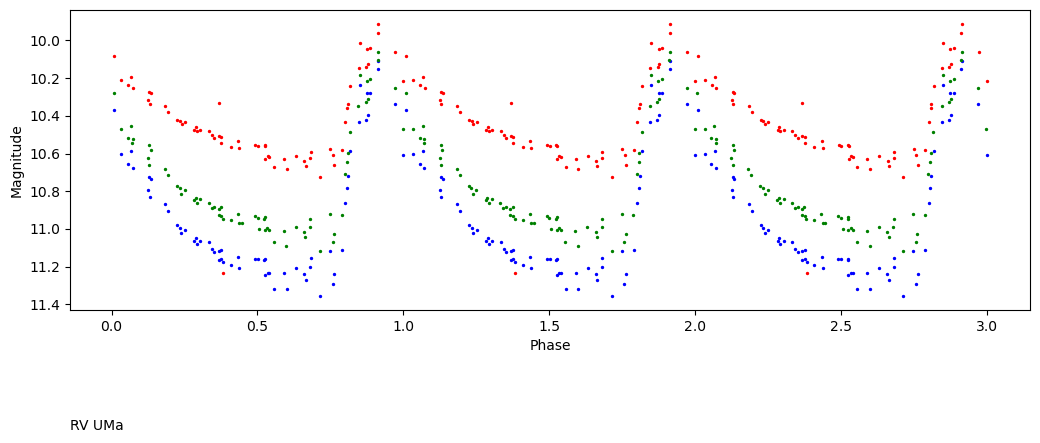

In [138]:
fig2_text = "RV UMa"

fig2 = plt.figure(figsize=(12,6))
ax2 = fig2.add_axes((.1,.4,.8,.5))
ax2.scatter(RV_UMa_g_phase, RV_UMa_g_phase_mag, marker='o', s=2, zorder=3, c='Green')
ax2.scatter(RV_UMa_bp_phase, RV_UMa_bp_phase_mag, marker='o', s=2, zorder=2, c='Blue')
ax2.scatter(RV_UMa_rp_phase, RV_UMa_rp_phase_mag, marker='o', s=2, zorder=1, c='Red')

ax2.set_xlabel("Phase")
ax2.set_ylabel("Magnitude")
ax2.yaxis.set_inverted(True)
fig2.text(.1,.2,fig2_text)
plt.show()

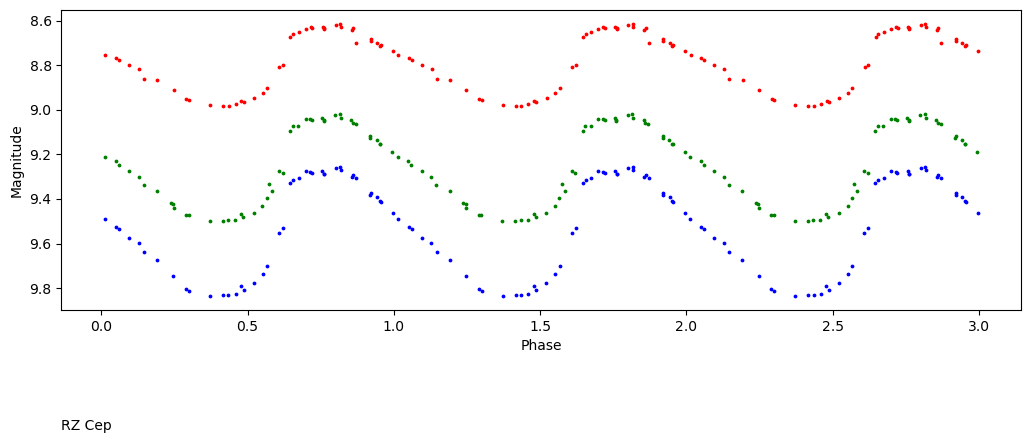

In [139]:
fig3_text = "RZ Cep"

fig3 = plt.figure(figsize=(12,6))
ax3 = fig3.add_axes((.1,.4,.8,.5))
ax3.scatter(RZ_Cep_g_phase, RZ_Cep_g_phase_mag, marker='o', s=3, zorder=3, c='Green')
ax3.scatter(RZ_Cep_bp_phase, RZ_Cep_bp_phase_mag, marker='o', s=3, zorder=2, c='Blue')
ax3.scatter(RZ_Cep_rp_phase, RZ_Cep_rp_phase_mag, marker='o', s=3, zorder=1, c='Red')

ax3.set_xlabel("Phase")
ax3.set_ylabel("Magnitude")
ax3.yaxis.set_inverted(True)
fig3.text(.1,.2,fig3_text)
plt.show()